In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV ,cross_val_score



# Load datasets

In [ ]:

train_data = pd.read_csv('/content/XY_train.csv')
test_data = pd.read_csv('/content/X_test.csv')


In [ ]:
train_data.head()


,Shares,Comments added,Likes (vs. dislikes) (%),Average view duration,Views,Subscribers,Impressions click-through rate (%)
0,2035.0,1578.0,97.95,0:09:32,4319500.0,3574.0,4.66
1,1070.0,1878.0,97.92,0:10:38,2522030.0,4845.0,5.14
2,1375.0,4314.0,97.54,0:09:31,3564849.0,8505.0,7.00
3,420.0,502.0,98.34,0:06:06,1148850.0,513.0,7.27
4,982.0,977.0,97.43,0:07:32,1559413.0,3865.0,5.08


In [ ]:
test_data.head()

,Shares,Comments added,Likes (vs. dislikes) (%),Average view duration,Subscribers,Impressions click-through rate (%),Views prediction
0,27558,3243,95.66,00:11:10,28895,4.84,NaN
1,575,942,98.10,00:10:59,879,5.99,NaN
2,5362,1903,95.28,00:06:27,10362,5.98,NaN
3,1231,465,93.65,00:10:26,3119,5.35,NaN
4,4115,2126,97.16,00:13:42,10311,3.55,NaN


# Data Preparation

In [ ]:

#'Average view duration' from hh:mm:ss to seconds
def duration_to_seconds(duration):
    if isinstance(duration, str) and ':' in duration:
        parts = list(map(int, duration.split(':')))
        return parts[0] * 3600 + parts[1] * 60 + parts[2]
    return None

train_data['Average view duration'] = train_data['Average view duration'].apply(duration_to_seconds)


numeric_columns = train_data.select_dtypes(include=[float]).columns
train_data[numeric_columns] = train_data[numeric_columns].fillna(train_data[numeric_columns].median())


missing_values_final = train_data.isnull().sum()

train_data_cleaned = train_data.head()
(train_data_cleaned, missing_values_final)


(   Shares  Comments added  Likes (vs. dislikes) (%)  Average view duration  \
 0  2035.0          1578.0                     97.95                  572.0   
 1  1070.0          1878.0                     97.92                  638.0   
 2  1375.0          4314.0                     97.54                  571.0   
 3   420.0           502.0                     98.34                  366.0   
 4   982.0           977.0                     97.43                  452.0   
 
        Views  Subscribers  Impressions click-through rate (%)  
 0  4319500.0       3574.0                                4.66  
 1  2522030.0       4845.0                                5.14  
 2  3564849.0       8505.0                                7.00  
 3  1148850.0        513.0                                7.27  
 4  1559413.0       3865.0                                5.08  ,
 Shares                                0
 Comments added                        0
 Likes (vs. dislikes) (%)              0
 Average v

# Cleaning , normalization and outlier detection and handling

In [ ]:
# Detect outliers
outliers_summary = {}
for column in numeric_columns:
    Q1 = train_data[column].quantile(0.25)
    Q3 = train_data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((train_data[column] < lower_bound) | (train_data[column] > upper_bound)).sum()
    outliers_summary[column] = outliers

outliers_summary

{'Shares': 44,
 'Comments added': 53,
 'Likes (vs. dislikes) (%)': 20,
 'Average view duration': 8,
 'Views': 55,
 'Subscribers': 59,
 'Impressions click-through rate (%)': 20}

Remaining outliers after capping: {'Shares': 0, 'Comments added': 0, 'Likes (vs. dislikes) (%)': 0, 'Views': 0, 'Subscribers': 0, 'Impressions click-through rate (%)': 0}


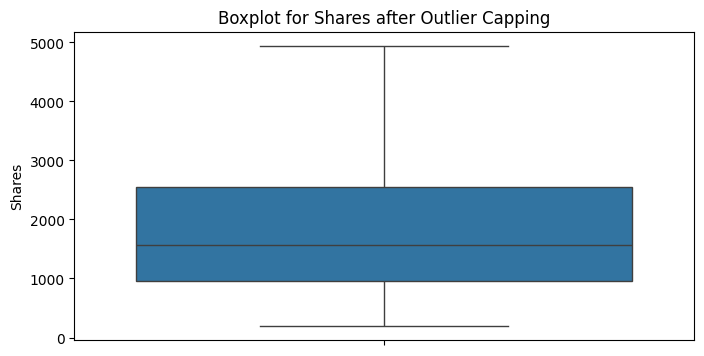

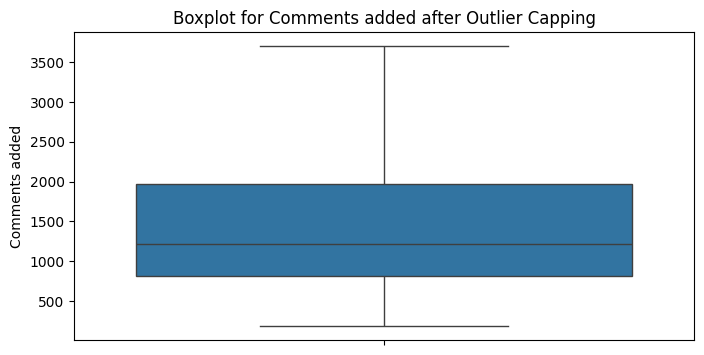

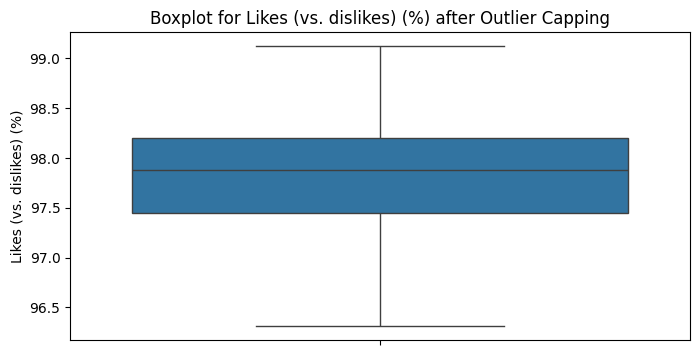

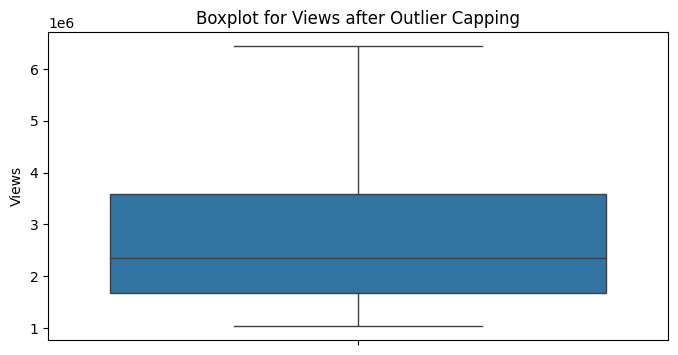

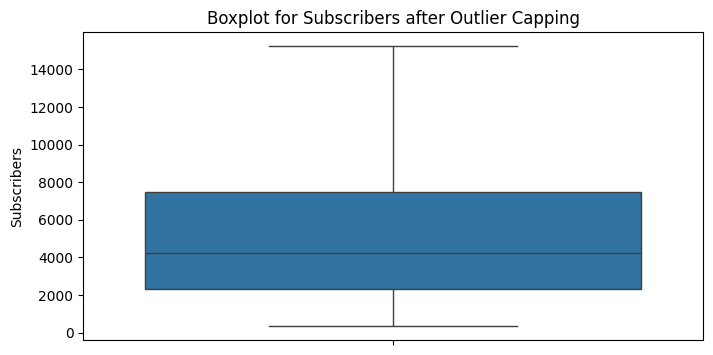

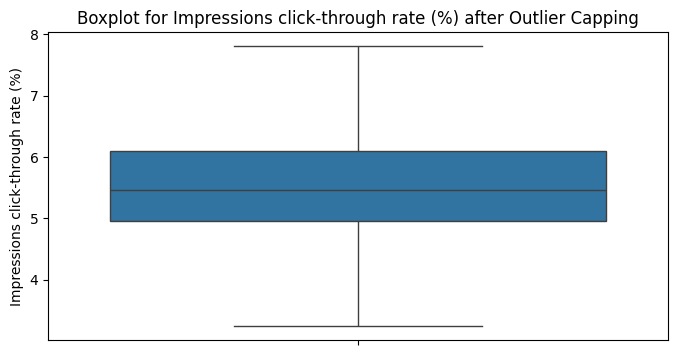

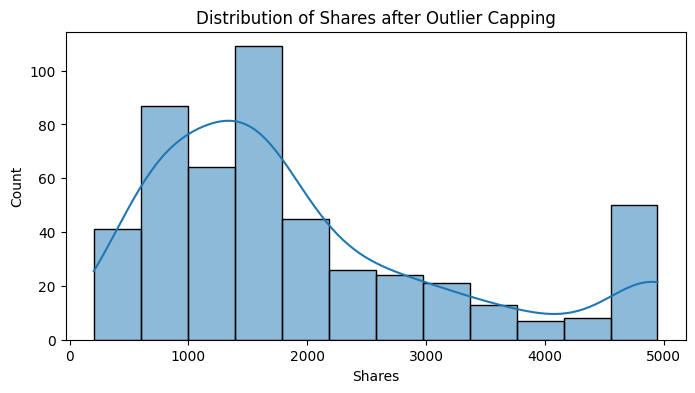

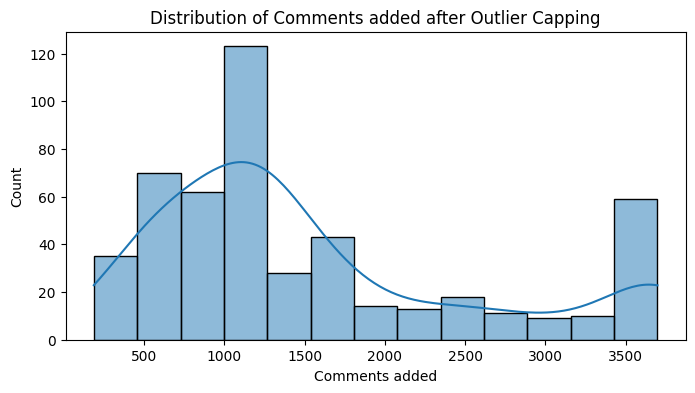

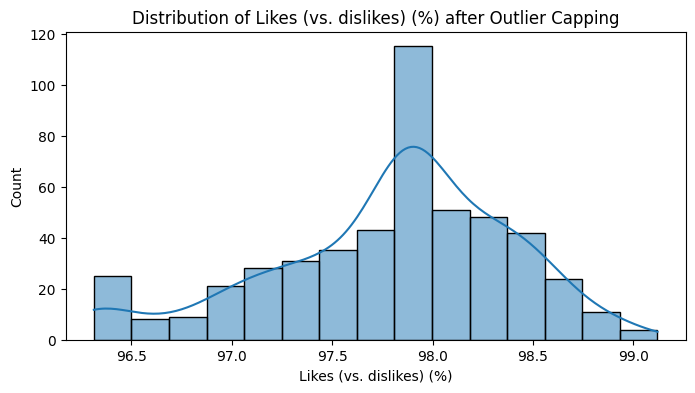

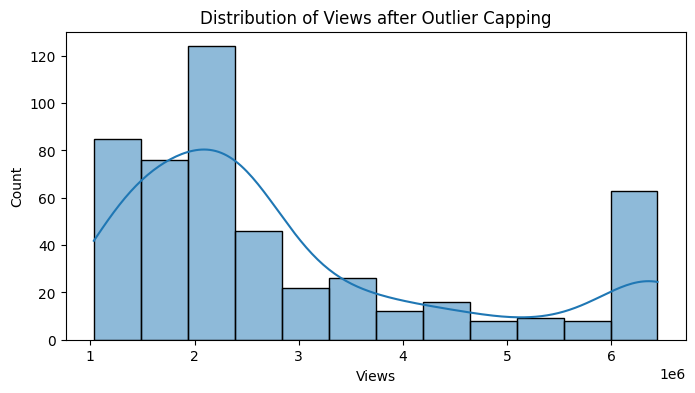

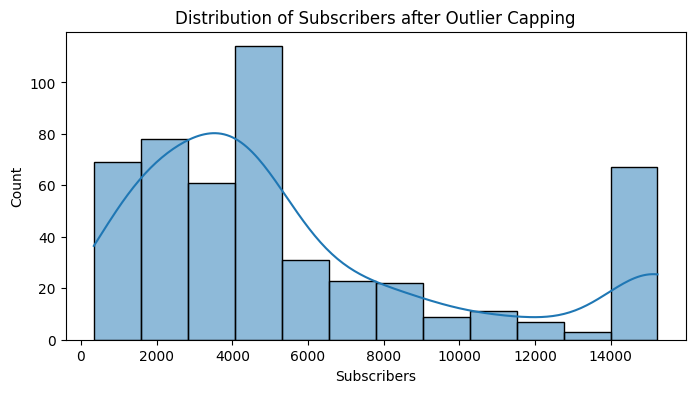

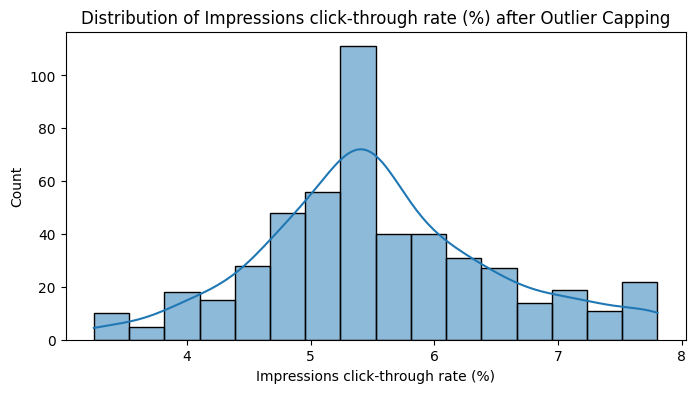

In [ ]:

train_data.dropna(how='all', inplace=True)


numeric_columns = ['Shares', 'Comments added', 'Likes (vs. dislikes) (%)',
                   'Views', 'Subscribers', 'Impressions click-through rate (%)']

# Function to cap outliers
def cap_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return column.clip(lower=lower_bound, upper=upper_bound)


for column in numeric_columns:
    train_data[column] = cap_outliers(train_data[column])

# Verify remaining outliers
outliers_summary = {}
for column in numeric_columns:
    Q1 = train_data[column].quantile(0.25)
    Q3 = train_data[column].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((train_data[column] < (Q1 - 1.5 * IQR)) |
                (train_data[column] > (Q3 + 1.5 * IQR))).sum()
    outliers_summary[column] = outliers


print("Remaining outliers after capping:", outliers_summary)


In [ ]:
# Drop the 'Average view duration' column
train_data = train_data.drop(columns=['Average view duration'])


cleaned_columns = train_data.columns
cleaned_data_head = train_data.head()

(cleaned_columns, cleaned_data_head)


(Index(['Shares', 'Comments added', 'Likes (vs. dislikes) (%)', 'Views',
        'Subscribers', 'Impressions click-through rate (%)'],
       dtype='object'),
    Shares  Comments added  Likes (vs. dislikes) (%)      Views  Subscribers  \
 0  2035.0         1578.00                     97.95  4319500.0       3574.0   
 1  1070.0         1878.00                     97.92  2522030.0       4845.0   
 2  1375.0         3698.25                     97.54  3564849.0       8505.0   
 3   420.0          502.00                     98.34  1148850.0        513.0   
 4   982.0          977.00                     97.43  1559413.0       3865.0   
 
    Impressions click-through rate (%)  
 0                                4.66  
 1                                5.14  
 2                                7.00  
 3                                7.27  
 4                                5.08  )

# Exploratory Data Analysis

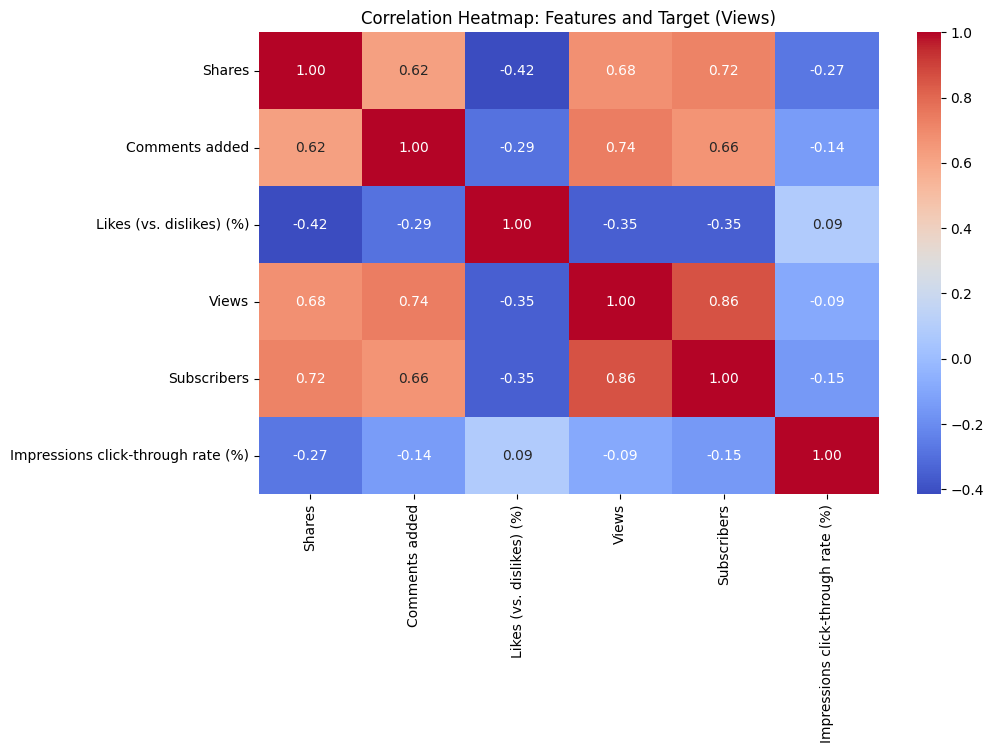

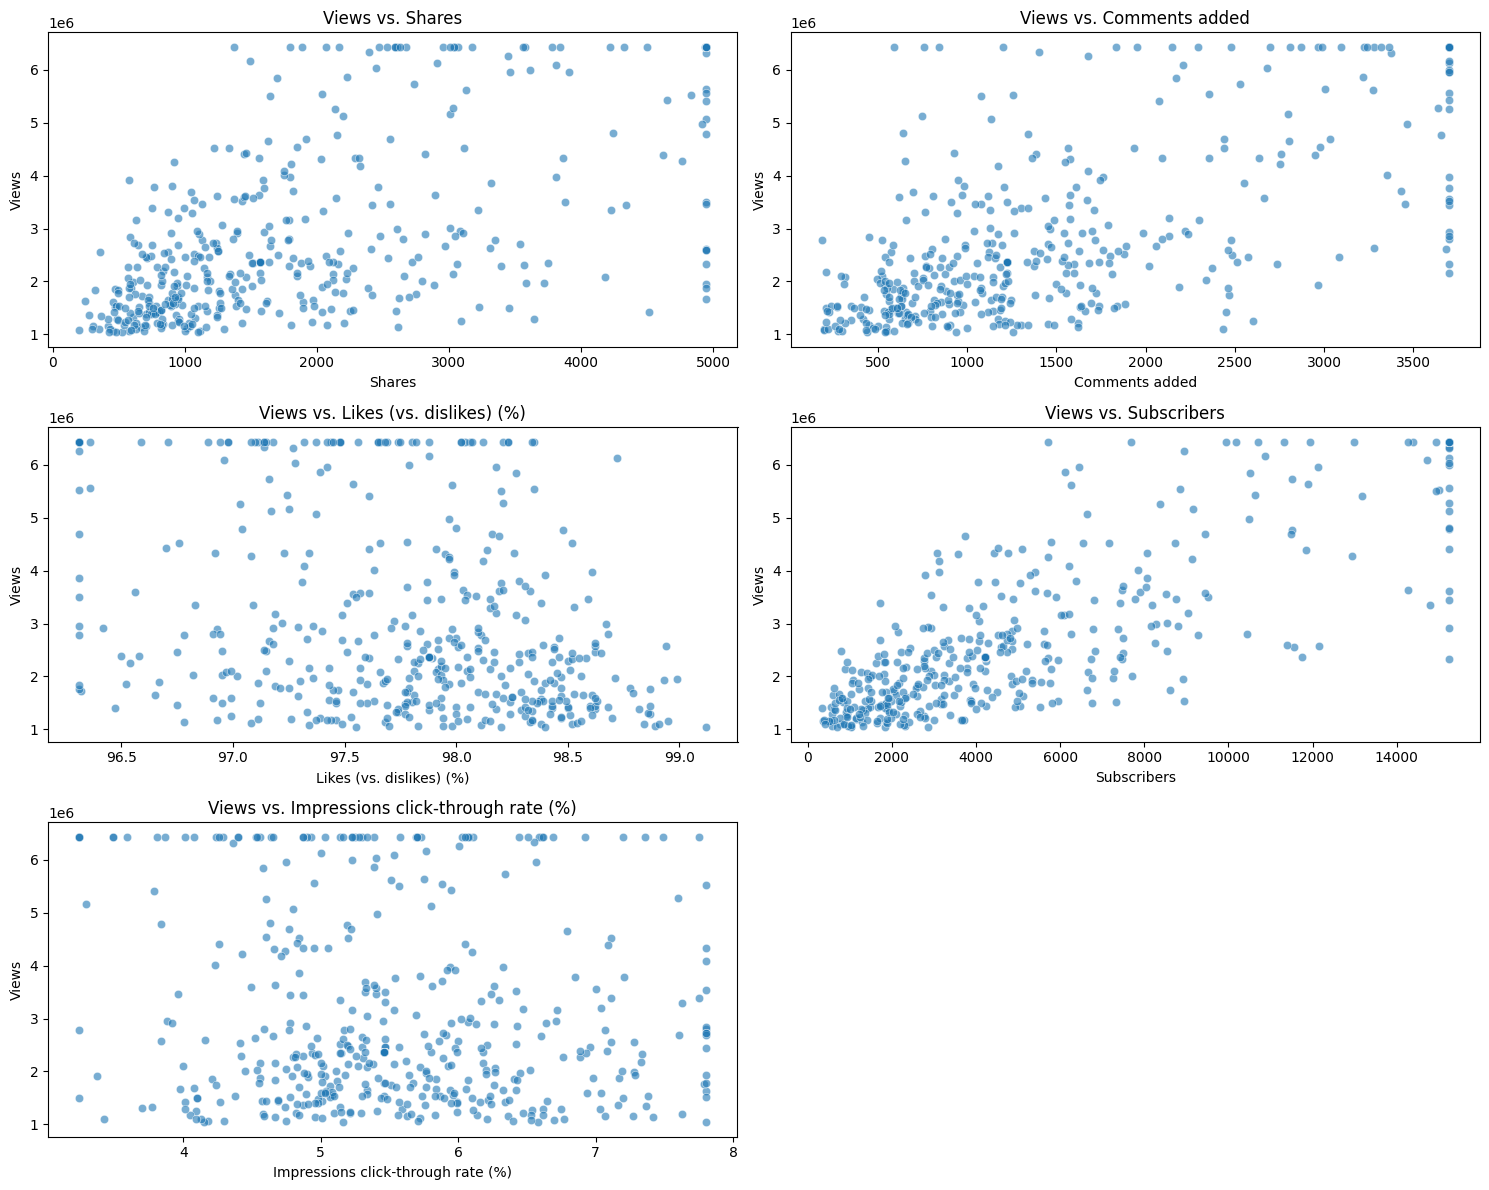

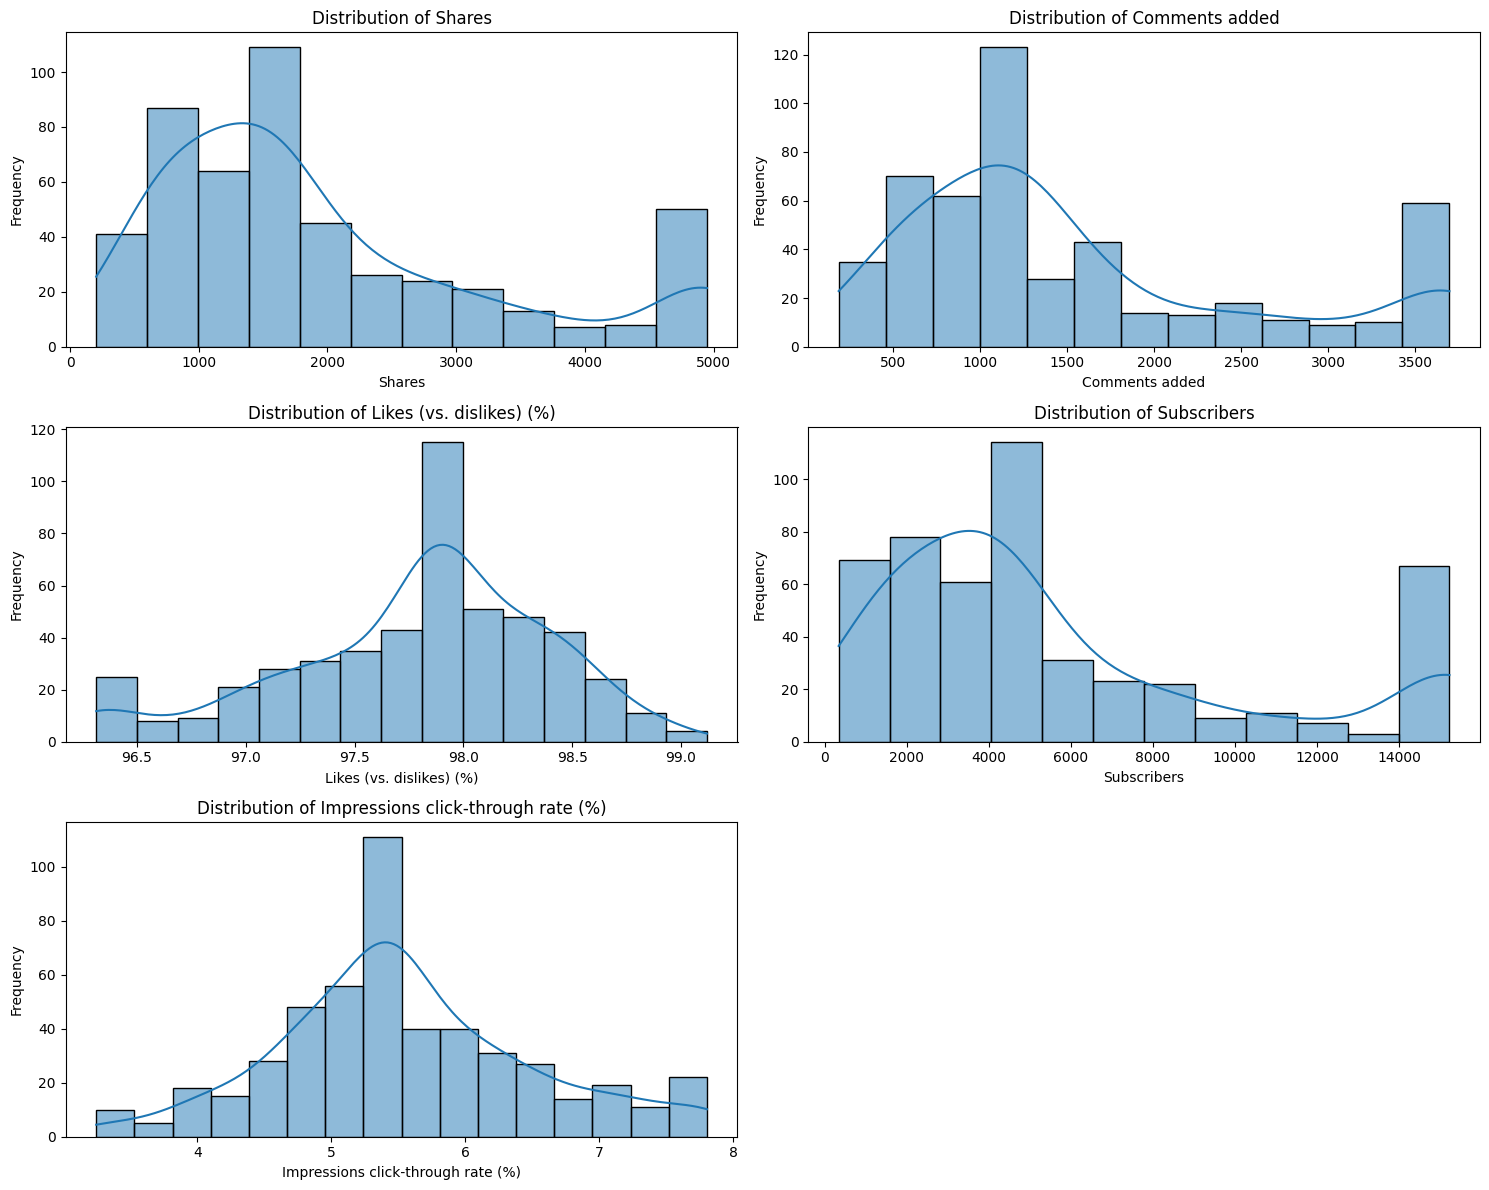

,Feature,VIF
0,Shares,7.601067
1,Comments added,6.420157
2,Likes (vs. dislikes) (%),44.080412
3,Subscribers,6.357197
4,Impressions click-through rate (%),36.830303


In [ ]:
# Correlation Heatmap to Understand Feature-Target Relationships

plt.figure(figsize=(10, 6))
correlation_matrix = train_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: Features and Target (Views)")
plt.show()

# Feature-Target Scatterplots to Identify Relationships
features = ['Shares', 'Comments added', 'Likes (vs. dislikes) (%)', 'Subscribers', 'Impressions click-through rate (%)']

fig, axs = plt.subplots(3, 2, figsize=(15, 12))
for i, feature in enumerate(features):
    sns.scatterplot(data=train_data, x=feature, y='Views', ax=axs[i // 2, i % 2], alpha=0.6)
    axs[i // 2, i % 2].set_title(f"Views vs. {feature}")
    axs[i // 2, i % 2].set_xlabel(feature)
    axs[i // 2, i % 2].set_ylabel("Views")


axs[2, 1].axis('off')
plt.tight_layout()
plt.show()

# Feature Distributions
fig, axs = plt.subplots(3, 2, figsize=(15, 12))
for i, feature in enumerate(features):
    sns.histplot(data=train_data, x=feature, kde=True, ax=axs[i // 2, i % 2])
    axs[i // 2, i % 2].set_title(f"Distribution of {feature}")
    axs[i // 2, i % 2].set_xlabel(feature)
    axs[i // 2, i % 2].set_ylabel("Frequency")

axs[2, 1].axis('off')
plt.tight_layout()
plt.show()

# Multicollinearity (Variance Inflation Factor)
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X_features = train_data.drop(columns=['Views'])  # Exclude target for VIF calculation
vif_data = pd.DataFrame()
vif_data['Feature'] = X_features.columns
vif_data['VIF'] = [variance_inflation_factor(X_features.values, i) for i in range(X_features.shape[1])]

# Display the VIF values
vif_data


# Model Training based on Selected Features

Best RMSE: 840947.0696838944 at round 36
MAE (Final Model): 495841.20454545453
RMSE (Final Model): 736253.9626720044


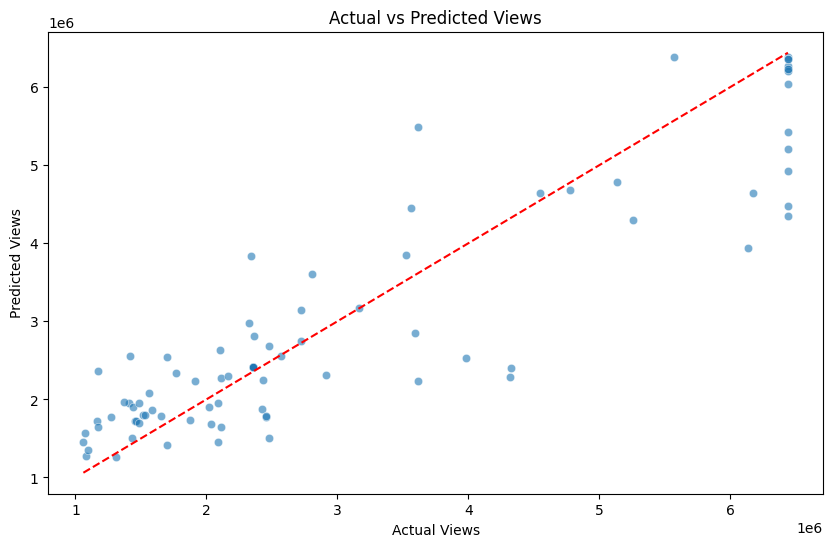

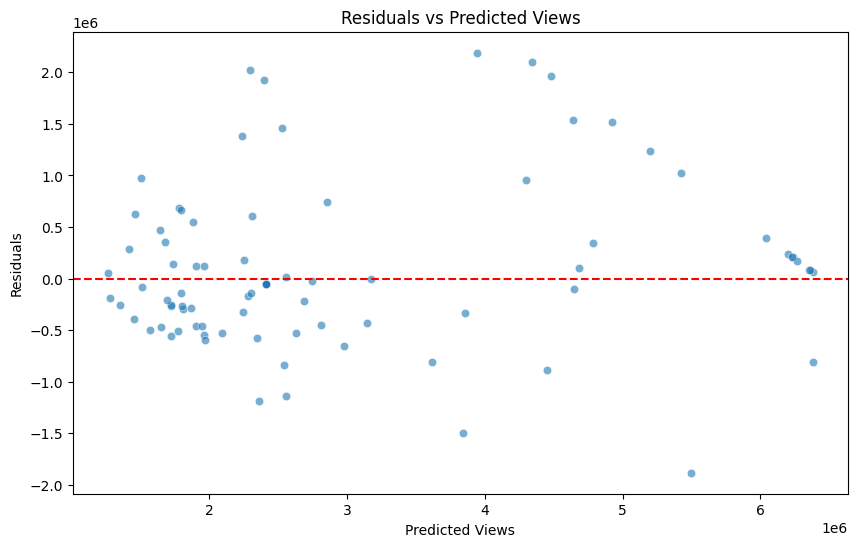

In [ ]:

X = train_data.drop(columns=['Views'])  # Features
y = train_data['Views']  # Target

# Split into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing - Log-transform and feature engineering
skewed_features = ['Shares', 'Subscribers', 'Comments added']
for feature in skewed_features:
    X_train[feature] = np.log1p(X_train[feature])
    X_val[feature] = np.log1p(X_val[feature])

X_train['Shares_Subscribers'] = X_train['Shares'] * X_train['Subscribers']
X_val['Shares_Subscribers'] = X_val['Shares'] * X_val['Subscribers']


scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dval = xgb.DMatrix(X_val_scaled, label=y_val)

#  parameter grid
params = {
    'max_depth': 4,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:squarederror'
}

# Cross-validation for hyperparameter tuning
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=200,
    nfold=3,
    metrics='rmse',
    early_stopping_rounds=10,
    as_pandas=True,
    seed=42
)


best_rmse = cv_results['test-rmse-mean'].min()
best_num_boost_round = cv_results['test-rmse-mean'].idxmin()
print(f"Best RMSE: {best_rmse} at round {best_num_boost_round}")

# Train the final model
final_model = xgb.train(params, dtrain, num_boost_round=best_num_boost_round)

#  Validate the model
y_pred_best = final_model.predict(dval)

# Calculate metrics
mae_best = mean_absolute_error(y_val, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_val, y_pred_best))

print(f"MAE (Final Model): {mae_best}")
print(f"RMSE (Final Model): {rmse_best}")

# Scatter plot: Actual vs Predicted
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_val, y=y_pred_best, alpha=0.6)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--')
plt.xlabel("Actual Views")
plt.ylabel("Predicted Views")
plt.title("Actual vs Predicted Views")
plt.show()

# Residual plot
residuals = y_val - y_pred_best
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_best, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Views")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Views")
plt.show()


# Feature Importance

  Feature  Importance
3      f3       104.0
1      f1       101.0
0      f0        76.0
2      f2        68.0
4      f4        63.0
5      f5        53.0


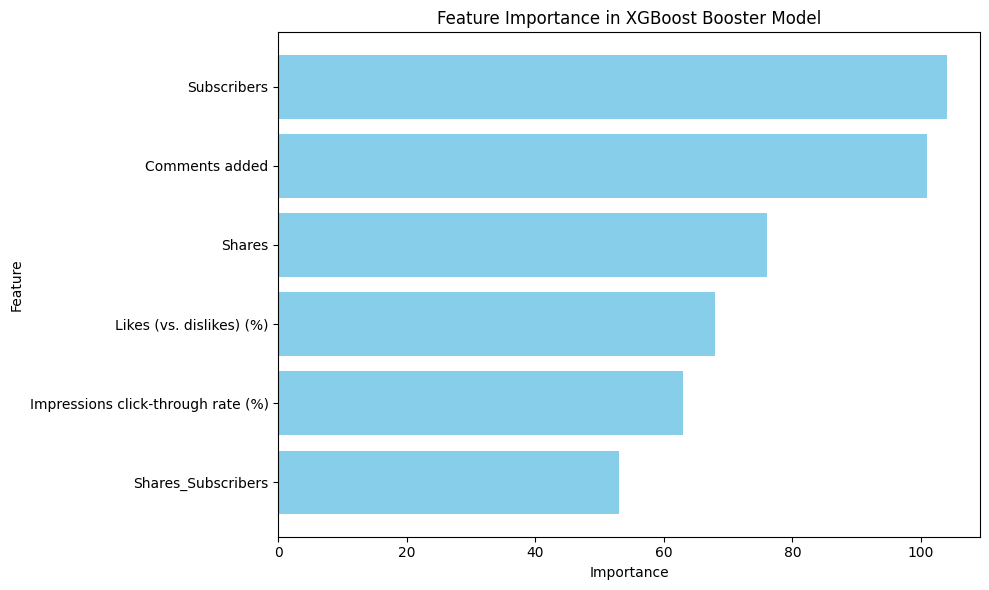

In [ ]:
# Extract feature importance
importance_dict = final_model.get_score(importance_type="weight")


feature_importance = pd.DataFrame({
    'Feature': list(importance_dict.keys()),
    'Importance': list(importance_dict.values())
}).sort_values(by='Importance', ascending=False)

print(feature_importance)
feature_map = {f"f{i}": name for i, name in enumerate(X_train.columns)}
feature_importance['Feature'] = feature_importance['Feature'].map(feature_map)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in XGBoost Booster Model")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



# Residual Analysis


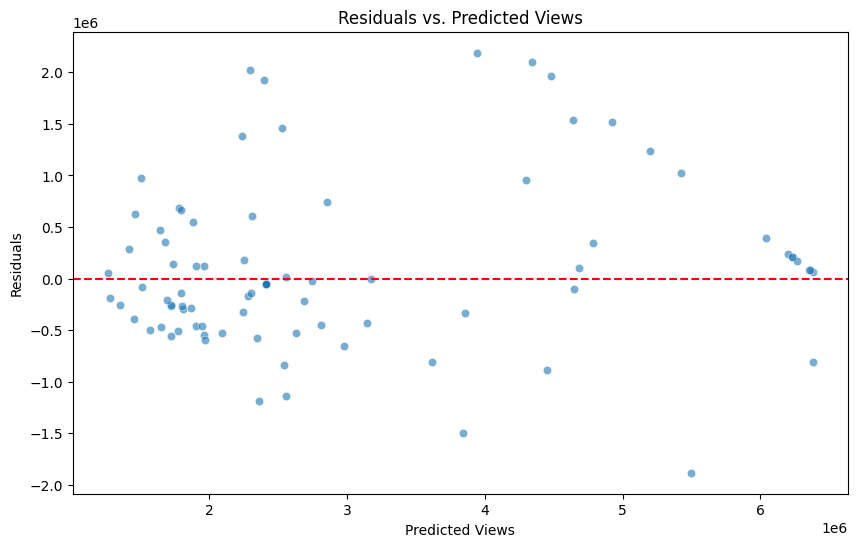

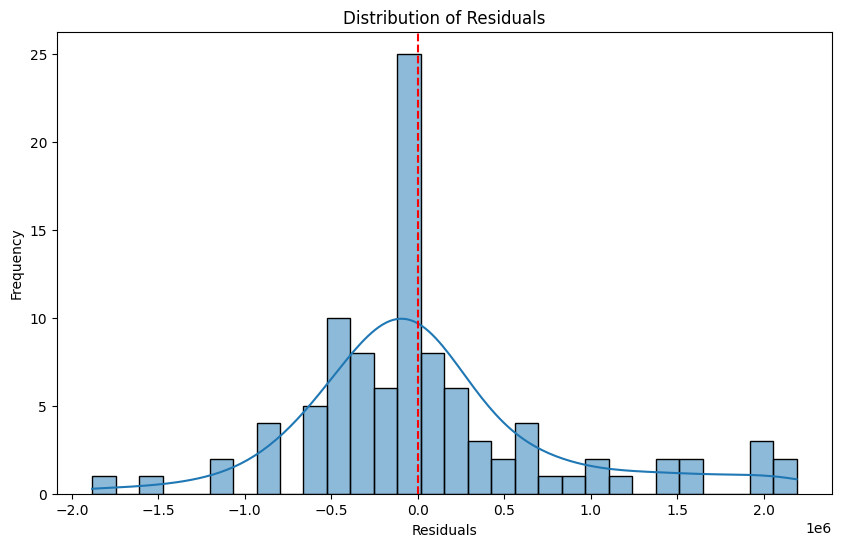

{'Mean Residual': 65760.29040404041,
 'Median Residual': -53154.5,
 'Standard Deviation of Residuals': 733311.3129880142}

In [ ]:
# Calculate residuals (difference between actual and predicted values)
residuals = y_val - y_pred_best

# Plot residuals vs. predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_best, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Views")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Views")
plt.show()

#  Plot residual distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()

#  Calculate basic residual statistics
residual_stats = {
    "Mean Residual": np.mean(residuals),
    "Median Residual": np.median(residuals),
    "Standard Deviation of Residuals": np.std(residuals)
}

residual_stats


# Testing Model

In [ ]:

test_data = test_data.drop(columns=['Shares_Subscribers''Views','Average view duration','Views prediction',], errors='ignore')  # Ignore if 'Views' is not present

# Apply log-transform to skewed features
skewed_features = ['Shares', 'Subscribers', 'Comments added']
for feature in skewed_features:
    test_data[feature] = np.log1p(test_data[feature])


test_data['Shares_Subscribers'] = test_data['Shares'] * test_data['Subscribers']

test_data_scaled = scaler.transform(test_data)
dtest = xgb.DMatrix(test_data_scaled)

# Predict with the trained model
test_predictions = final_model.predict(dtest)

test_data['Predicted Views'] = test_predictions
test_data.to_csv('X_test_predictions.csv', index=False)
print("Predictions saved to 'X_test_predictions.csv'.")


Predictions saved to 'X_test_predictions.csv'.


# Visualize Results

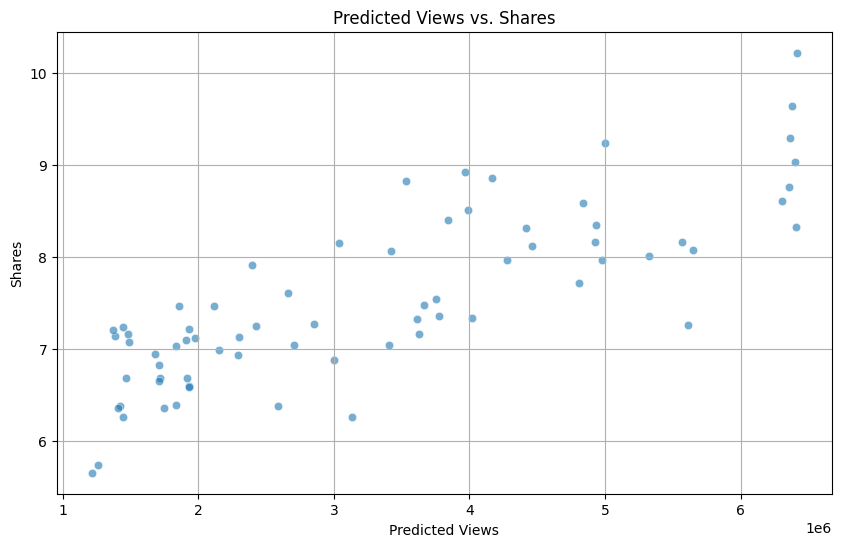

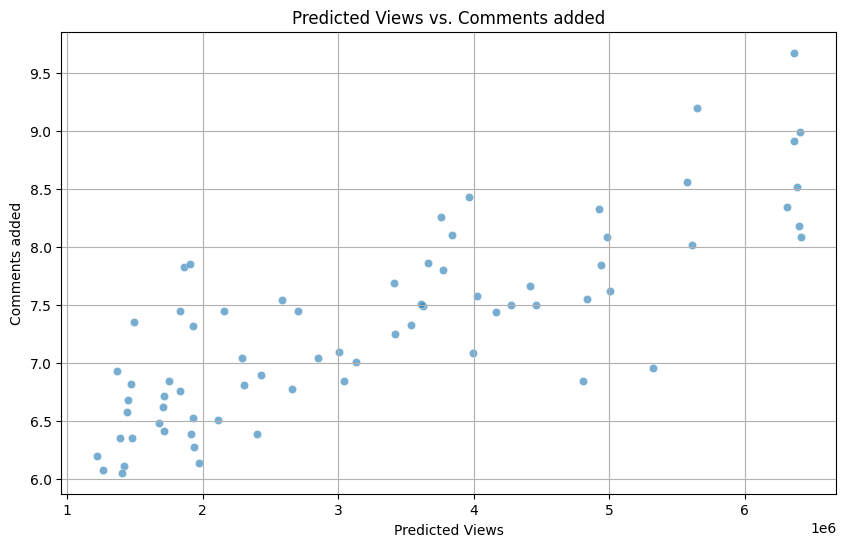

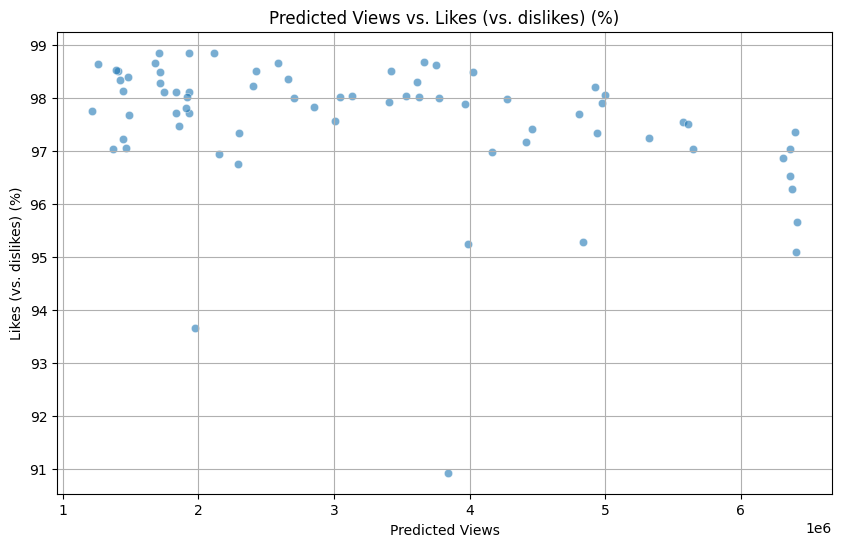

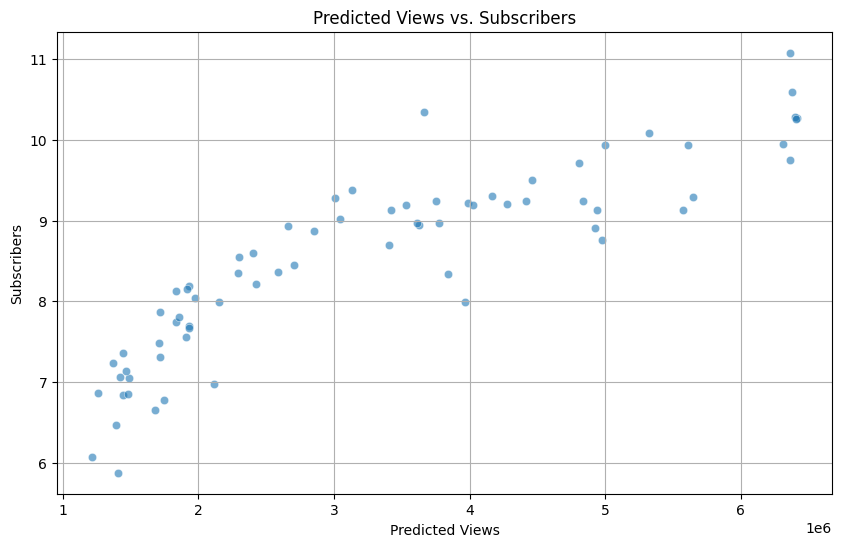

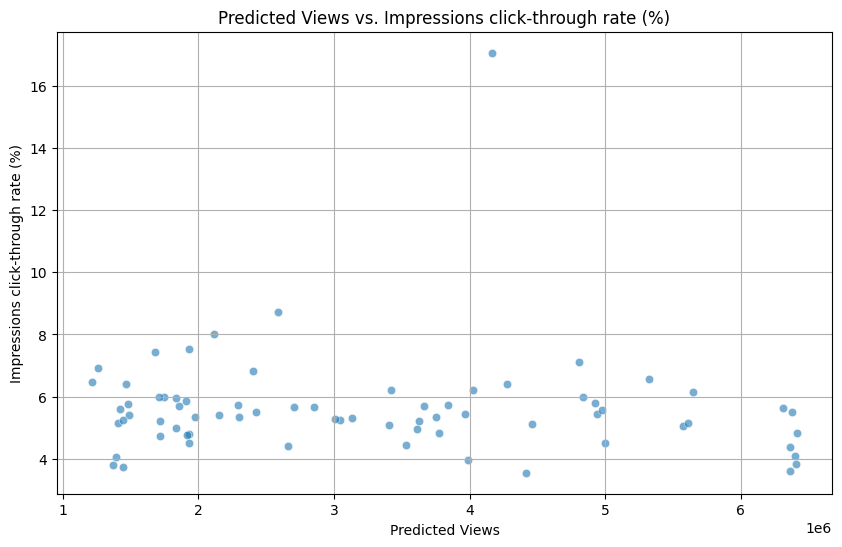

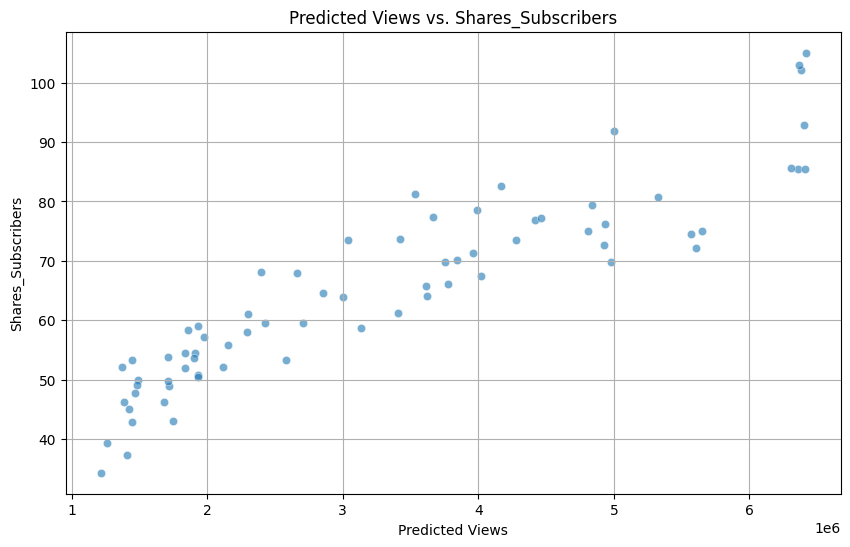

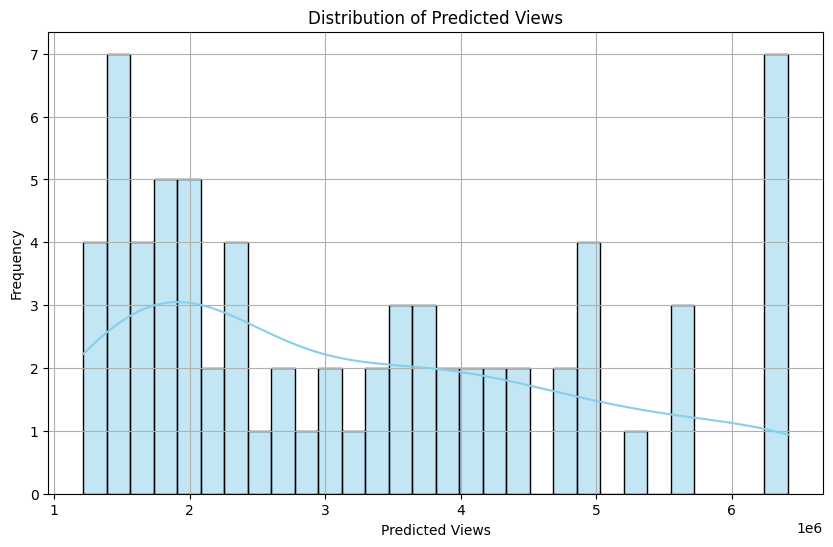

In [ ]:
predicted_test_data = pd.read_csv('X_test_predictions.csv')

# Extract Predicted Views and other features
features = predicted_test_data.columns.drop(['Predicted Views'])

for feature in features:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=predicted_test_data['Predicted Views'], y=predicted_test_data[feature], alpha=0.6)
    plt.title(f'Predicted Views vs. {feature}')
    plt.xlabel('Predicted Views')
    plt.ylabel(feature)
    plt.grid(True)
    plt.show()


plt.figure(figsize=(10, 6))
sns.histplot(predicted_test_data['Predicted Views'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Predicted Views')
plt.xlabel('Predicted Views')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
